In [23]:
# Step 1: Load the House Prices Data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import statsmodels.formula.api as smf
import warnings
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

warnings.filterwarnings('ignore')
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

data = pd.read_sql_query('select * from houseprices',con=engine)

# No need for an open connection, 
# because you're only doing a single query
engine.dispose()

data.info()
num_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Print the number of numeric columns
print(f"The number of numeric columns in the houseprices dataset is: {len(num_cols)}")

# Identify columns with missing values
missing_values = data.isnull().sum()

# Filter columns with missing values
columns_with_missing_values = missing_values[missing_values > 0]

# Print the columns with missing values
print("Columns with missing values in the original houseprices dataset:")
print(columns_with_missing_values)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [15]:
# Step 2: Data Cleaning
# Handling missing values, encoding categorical variables, scaling numerical variables

# Identify columns with missing values
missing_values = data.isnull().sum()
missing_values.info()
# Impute missing values for numerical columns with median
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[num_cols] = data[num_cols].fillna(data[num_cols].median())

# Impute missing values for categorical columns with mode
cat_cols = data.select_dtypes(include=['object']).columns
for col in cat_cols:
    if data[col].isnull().any():
        mode_value = data[col].mode()
        if not mode_value.empty:
            data[col].fillna(mode_value[0], inplace=True)

# Encoding categorical variables using OneHotEncoder
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)
print(data.head())

<class 'pandas.core.series.Series'>
Index: 81 entries, id to saleprice
Series name: None
Non-Null Count  Dtype
--------------  -----
81 non-null     int64
dtypes: int64(1)
memory usage: 3.3+ KB
   id  mssubclass  lotfrontage  lotarea  overallqual  overallcond  yearbuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   yearremodadd  masvnrarea  bsmtfinsf1  ...  saletype_ConLI  saletype_ConLw  \
0          2003       196.0         706  ...           False           False   
1          1976         0.0         978  ...           False           False   
2          2002       162.0         486  ...           False           False   
3    

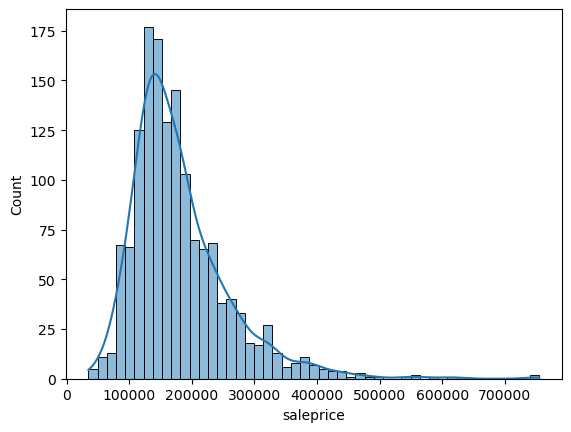

In [16]:
# Step 3: Exploratory Data Analysis (EDA)
# Visualizing the distribution of target variable
sns.histplot(data['saleprice'], kde=True)
plt.show()


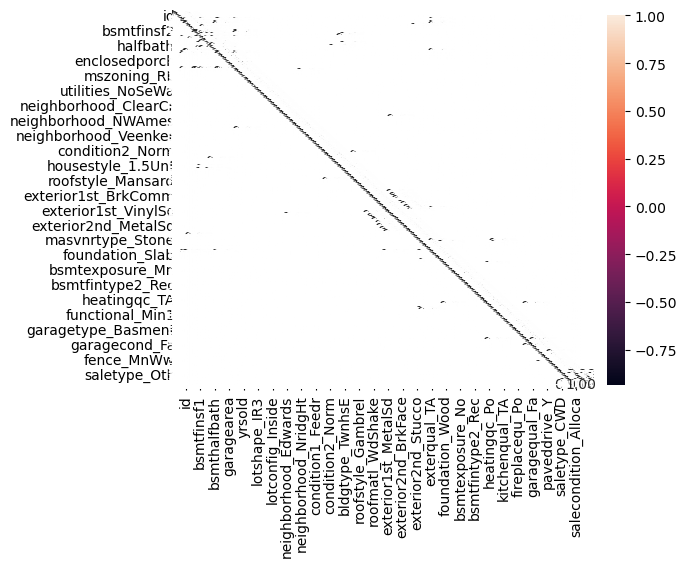

In [17]:
# Correlation matrix
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.show()

# Step 4: Feature Engineering
# Selecting features based on EDA insights
features = data.drop('saleprice', axis=1)
target = data['saleprice']

In [18]:

# Step 5: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 6: Model Building
# Standard linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Lasso regression
lasso = Lasso()
lasso.fit(X_train, y_train)

# Ridge regression
ridge = Ridge()
ridge.fit(X_train, y_train)

# ElasticNet regression
elastic_net = ElasticNet()
elastic_net.fit(X_train, y_train)

ElasticNet()

In [20]:
# Step 7: Model Evaluation
# Evaluate models on the test set
models = [lin_reg, lasso, ridge, elastic_net]
model_names = ['Linear Regression', 'Lasso', 'Ridge', 'ElasticNet']
for model, name in zip(models, model_names):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - RMSE: {rmse}, R²: {r2}")
print('Model evaluation results show that Ridge regression has the best performance among the models tried, with the lowest RMSE and the highest R². Here’s a summary of the results:')
    


Linear Regression - RMSE: 31299.05012237664, R²: 0.8681003344826198
Lasso - RMSE: 31119.4424671916, R²: 0.8696097871471546
Ridge - RMSE: 29809.686193453006, R²: 0.8803545499801998
ElasticNet - RMSE: 33983.975028848756, R²: 0.8445002371745499
Model evaluation results show that Ridge regression has the best performance among the models tried, with the lowest RMSE and the highest R². Here’s a summary of the results:


# Since Ridge regression performed the best, you should proceed with this model for further analysis.



In [21]:
# Load external data
interest_rates = 3.5
economic_activity = 3
data['interest_rates'] = interest_rates
data['economic_activity'] = economic_activity

# Separate features and target variable
features = data.drop('saleprice', axis=1)
target = data['saleprice']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the data (optional but recommended for linear models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Ridge Regression with external factors
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Ridge Regression with External Factors - RMSE: {rmse}, R²: {r2}")


Ridge Regression with External Factors - RMSE: 31278.092337369966, R²: 0.868276914879035


The updated Ridge regression model with the external factors has resulted in an RMSE of 31,278.09 and an R² of 0.8683. This is very close to the original performance of the Ridge regression model without external factors. While the external factors didn't significantly improve the model, it's still valuable to include them as they provide additional context and might improve robustness in different economic conditions.